In [193]:
import warnings
warnings.filterwarnings("ignore")



import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score,  GridSearchCV
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
import os
from os.path import join

# train_data_path = join('../input', 'train.csv')
# sub_data_path = join('../input', 'test.csv')

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)



/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [195]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [196]:
y = data['price']
del data['price']

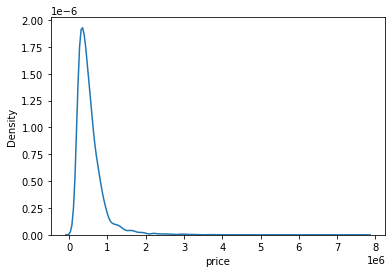

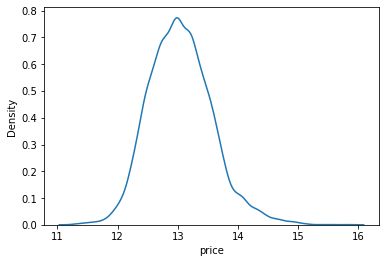

In [197]:
sns.kdeplot(y)
plt.show()

#  og1p price 사용
# 로그스케일 가격으로 변환
y = np.log1p(y)
# 나중에 y_pred = np.expm1(y_pred)

sns.kdeplot(y)
plt.show()

In [198]:
train_len = len(data)
data = pd.concat((data, sub), axis=0) # data 행 아래쪽에  sub를 이어붙인다

In [199]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 데이터 전처리 
각 변수들에 대해 결측과 분포를 확인해 계산하기 접합하게 변화시킵니다.
### 결측치 확인
missingno 라이브러리의 matrix 함수 사용

<AxesSubplot:>

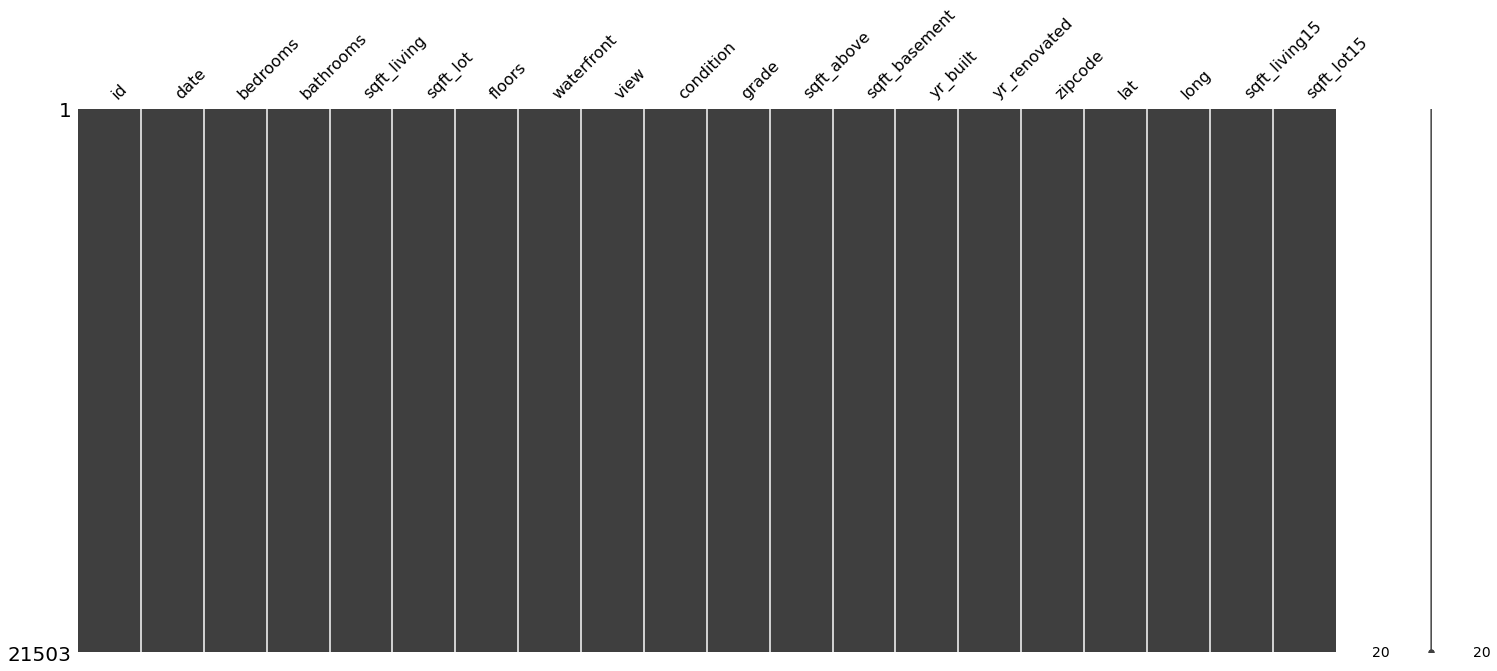

In [200]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [201]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 제거합니다.
date 변수는 연월일시간으로 값을 가지고 있는데, 적당한 정수로 변환시킵니다.

In [202]:
sub_id = data['id'][train_len:]
del data['id']
# data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)
print(data.columns)
data.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 데이터의 분포 확인


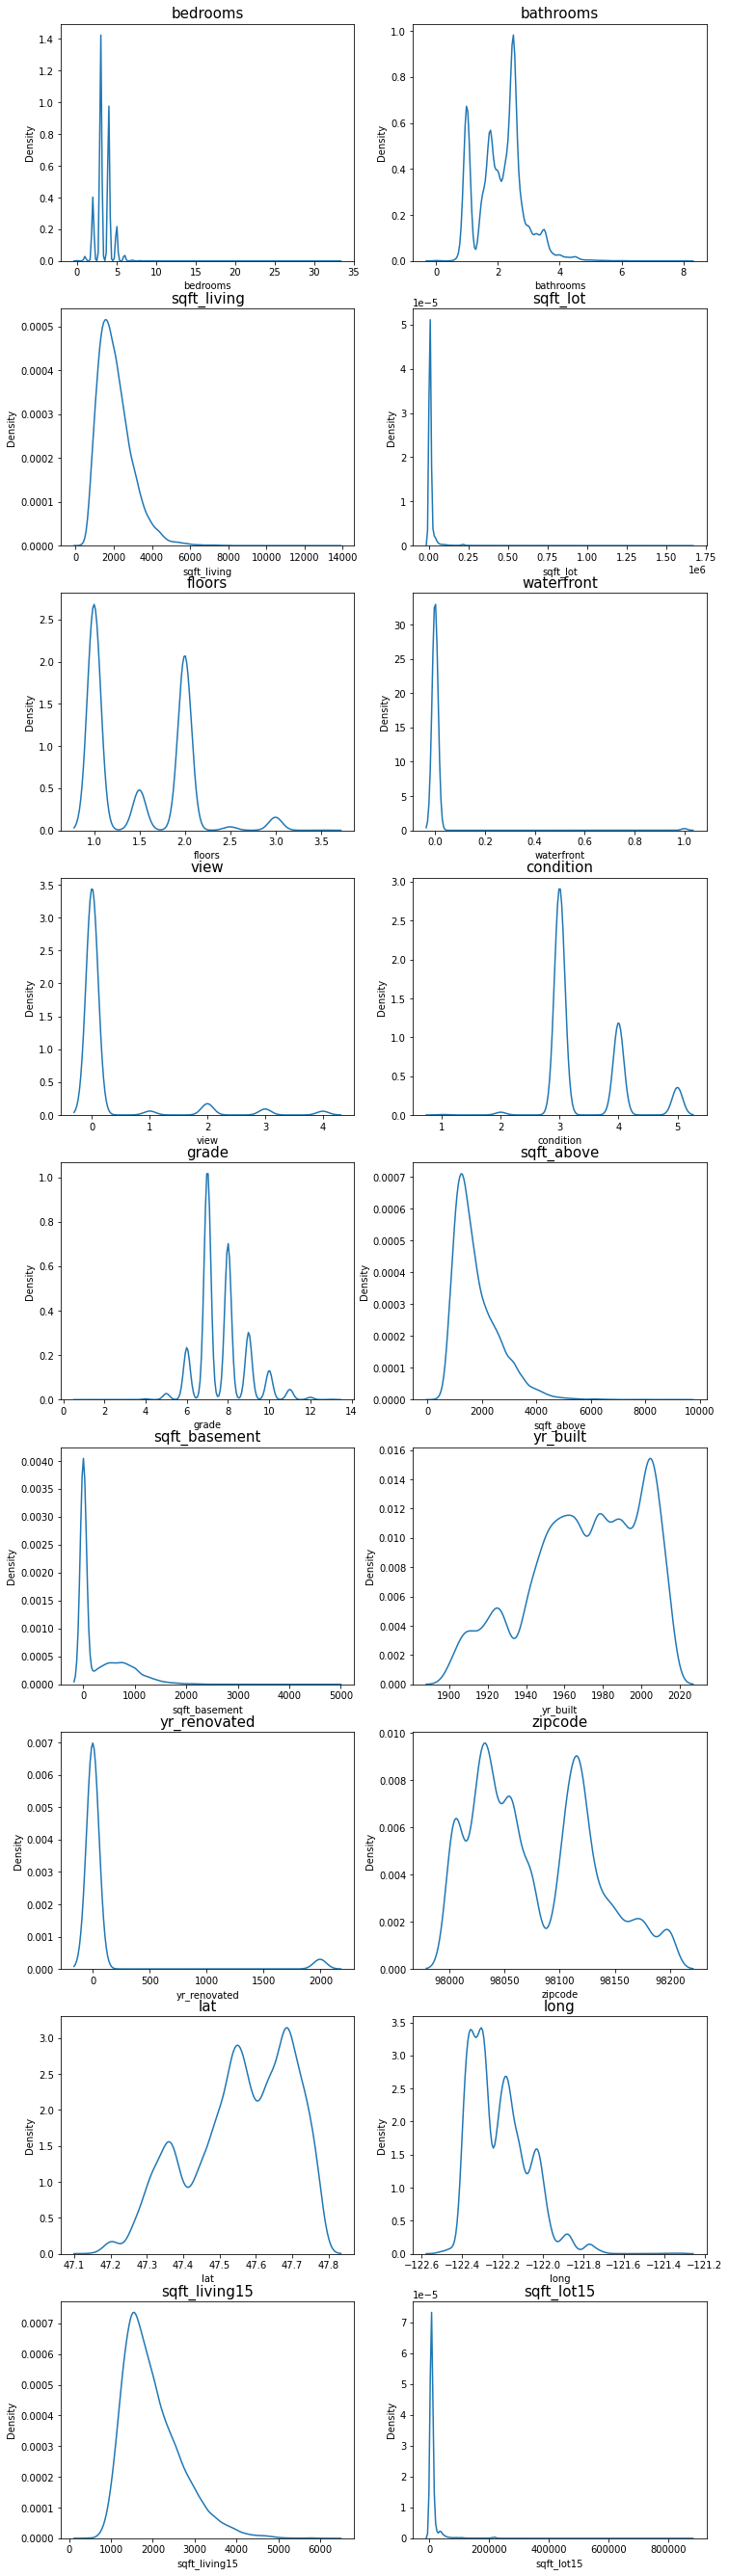

In [203]:
fig, ax = plt.subplots(9, 2, figsize=(12, 48))

# columns_idx 변수(columns_idx==0인 경우 제외) 분포를 확인합니다.
columns_idx = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data= data[columns[columns_idx]], ax=ax[row][col])
        ax[row][col].set_title(columns[columns_idx], fontsize=15)
        columns_idx += 1
        if columns_idx == 19 :
            break  

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 등 변수가 한쪽으로 치우친 것을
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [204]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)


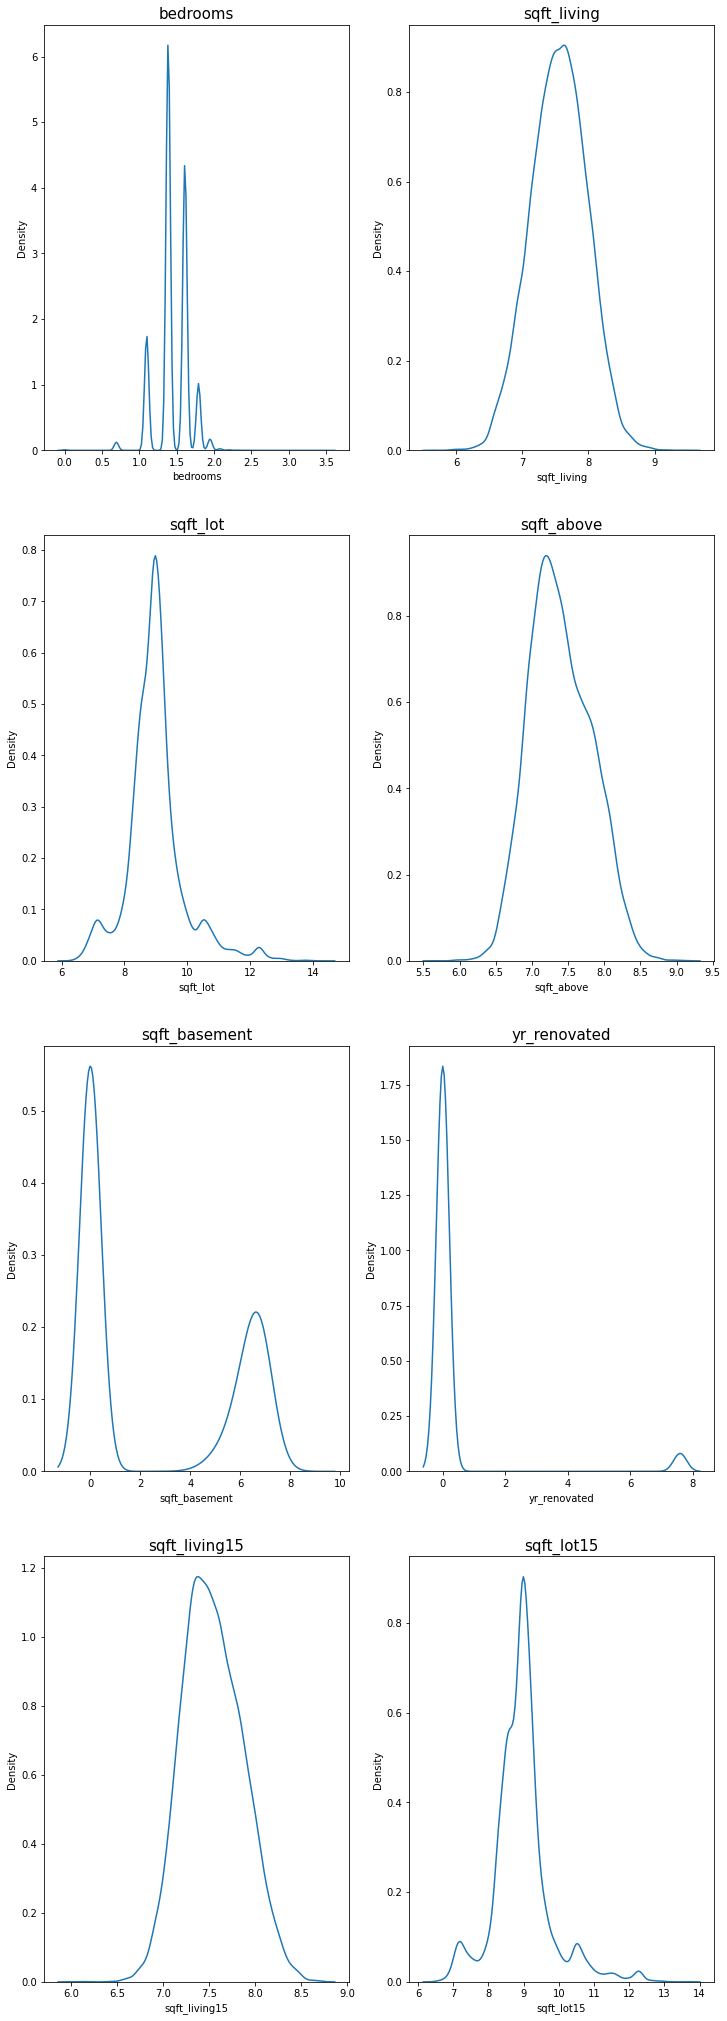

In [205]:

fig, ax = plt.subplots(4, 2, figsize=(12, 36))
# columns_idx 변수 0~7 8개의 분포를 확인합니다.
columns_idx = 0
for row in range(4):
    for col in range(2):
        sns.kdeplot(data= data[skew_columns[columns_idx]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[columns_idx], fontsize=15)
        columns_idx += 1
        if columns_idx == 8: # 데이터 컬럼이 8개까지 밖에 없다.
            break           


어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [206]:
x   = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]

## 3. 모델링

여러가지 모델 중 가장 뛰어난 모델을 사용하겠습니다.

In [207]:
random_state=2022

gboost     = GradientBoostingRegressor(random_state=random_state)
# xgboost    = xgb.XGBRegressor(random_state=random_state)
xgboost    = xgb.XGBRegressor(booster = 'gbtree', learning_rate = 0.1, min_child_weight= 10.00, n_estimators =1000, n_jobs = -1, random_state=random_state)

lightgbm   = lgb.LGBMRegressor(n_jobs=- 1, random_state=random_state) # LGBMRegressor은 찾아낸 최적값보다 디폴트가 점수가 높게 나옴
# lightgbm   = lgb.LGBMRegressor(learning_rate = 0.0100 , min_child_weight = 0.1, n_estimators = 1000, num_iterations = 500, n_jobs = -1,random_state=random_state)


rdforest   = RandomForestRegressor(n_estimators=1000, random_state=random_state, n_jobs = -1)

from sklearn import linear_model
rregression= linear_model.Ridge(alpha=.5, random_state=random_state)
rcvregression= linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))

from sklearn import svm
svm        = svm.SVR()

from sklearn.ensemble import AdaBoostRegressor
abr        = AdaBoostRegressor(n_estimators=1000,random_state=random_state)

from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
br         = BaggingRegressor(base_estimator=SVR(), n_estimators=1000, random_state=random_state)

from sklearn.ensemble import ExtraTreesRegressor
etr        = ExtraTreesRegressor(n_estimators=1000, random_state=random_state, n_jobs = -1)

from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

r1   = gboost
r2   = xgboost
r3   = lightgbm
r4   = rdforest
r5   = etr

from sklearn.ensemble import StackingRegressor
estimators = [('xgb', r2), ('lgb', r3)]
sre = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=1000,
                                          random_state=random_state)
)


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
# vr = VotingRegressor([('xgb', r2), ('lgb', r3), ('etr', r5)])
vr = VotingRegressor([('xgb', r2), ('lgb', r3)])

'''
r2   = xgb.XGBRegressor(random_state=random_state)
r3   = lgb.LGBMRegressor(random_state=random_state)
r5   = ExtraTreesRegressor(n_estimators=1000, random_state=random_state)

이 세개를 VotingRegressor로 활용하는 것이 성적이 가장 좋음.
세개의 파라미터만 좀 조절해서 VotingRegressor로 최종 결론을 내리는 것으로 결정
'''

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':sre,    'name':'StackingRegressor'},
          {'model':vr,    'name':'VotingRegressor'}
         ]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [209]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))                                                  

In [210]:
get_cv_score(models)

Model XGBoost CV score : 0.9040
Model LightGBM CV score : 0.9025
Model StackingRegressor CV score : 0.8914
Model VotingRegressor CV score : 0.9078


###회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
###R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현하며 네가지 모델이 0.9에 근접한 값을 나타냅니다.

In [211]:
models = [{'model':etr,    'name':'ExtraTreesRegressor'}]
get_cv_score(models)


Model ExtraTreesRegressor CV score : 0.8914


###VotingRegressor와 StackingRegressor에 모델 세개를 사용해서 비교해 보았다. 
###StackingRegressor는 약간의 개선이 있었으나 VotingRegressor는 오히려 점수가 낮아졌다. 

In [212]:
vr3 = VotingRegressor([('xgb', r2), ('lgb', r3), ('etr', r5)])

from sklearn.ensemble import StackingRegressor
estimators = [('xgb', r2), ('lgb', r3), ('etr', r5)]
sre3 = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=1000,
                                          random_state=random_state)
)

models = [{'model':sre3,    'name':'StackingRegressor'},
          {'model':vr3,    'name':'VotingRegressor'}
         ]

get_cv_score(models)

Model StackingRegressor CV score : 0.8968
Model VotingRegressor CV score : 0.9070


### Make Submission

###가장 점수가 높게 나온 VotingRegressor만을 사용하였다.

In [213]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [214]:
models = [{'model':vr,    'name':'VotingRegressor'}]
# AveragingBlending 함수를 사용하였지만 우수한 모델 하나만 사용해 평균은 아니다.
y_pred = AveragingBlending(models, x, y, sub)

In [215]:
#  y = np.log1p(y)으로 변환했던 가격을
# 로그스케일 가격을 원래대로 돌려놓음
y_pred = np.expm1(y_pred)

In [216]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [217]:
sub.to_csv('submission.csv', index=False)

In [218]:
df = pd.read_csv('submission.csv')
df    # df 표시

,id,price
0,15035,5.069466e+05
1,15036,4.740745e+05
2,15037,1.385730e+06
3,15038,3.036576e+05
4,15039,3.291504e+05
...,...,...
6463,21498,2.365981e+05
6464,21499,3.969437e+05
6465,21500,4.703627e+05
6466,21501,3.273779e+05


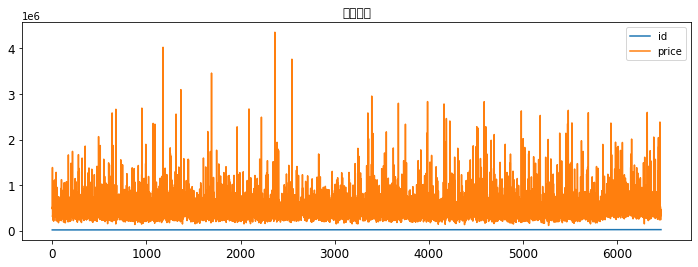

In [219]:
ax = df.plot(kind='line', title='집값예상', figsize=(12, 4), legend=True, fontsize=12)

###아래는 각 모델의 최적 하이퍼변수 값을 찾는 과정

In [220]:
lightgbm   = lgb.LGBMRegressor(random_state=random_state)

'''
LGBMRegressor
__init__(boosting_type='gbdt', num_leaves=31, max_depth=- 1, 
learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
objective=None, class_weight=None, min_split_gain=0.0, 
min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, 
reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split', **kwargs)

'''

param_grid = {
 'learning_rate'  :[0.0001, 0.001, 0.01],
  'num_iterations' : [10, 100, 500],
  'n_estimators'  :[100, 1000],
 'min_child_weight':[0.001, 0.01, 0.1],
}

model = lightgbm

# x.values, y

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    #  1. GridSearchCV 모델로 `model`을 초기화합니다.
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
    
    #  2. 모델을 fitting 합니다.
    grid_model.fit(train, y)
    
    #  3. params, score에 각 조합에 대한 결과를 저장합니다.
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    #  4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 
    #  점수가 높은 순서로 정렬한 `results`를 반환합니다.
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    
    sorted_results = results.sort_values(by = 'RMSLE', ascending=True)
    
    return sorted_results


# my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,learning_rate,min_child_weight,n_estimators,num_iterations,score,RMSLE
53,0.0100,0.100,1000,500,-0.028964,0.170187
50,0.0100,0.100,100,500,-0.028964,0.170187
47,0.0100,0.010,1000,500,-0.028964,0.170187
44,0.0100,0.010,100,500,-0.028964,0.170187
38,0.0100,0.001,100,500,-0.028964,0.170187
41,0.0100,0.001,1000,500,-0.028964,0.170187
52,0.0100,0.100,1000,100,-0.081080,0.284746
37,0.0100,0.001,100,100,-0.081080,0.284746
40,0.0100,0.001,1000,100,-0.081080,0.284746
43,0.0100,0.010,100,100,-0.081080,0.284746


In [221]:
xgboost    = xgb.XGBRegressor(random_state=random_state)

'''
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                 importance_type='gain', interaction_constraints='',
                 learning_rate=0.1, max_delta_step=0, max_depth=5,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                 tree_method='exact', validate_parameters=1, verbosity=None)
'''

param_grid = {
     'booster' : ['gbtree', 'gblinear','dart가'],
     'learning_rate'  :[0.001, 0.01, 0.1],
     'n_estimators'  :[100, 1000],
     'min_child_weight':[0.01, 0.1, 10],
}

model = xgboost

my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,booster,learning_rate,min_child_weight,n_estimators,score,RMSLE
17,gbtree,0.100,10.00,1000,-0.026662,0.163284
15,gbtree,0.100,0.10,1000,-0.026706,0.163421
13,gbtree,0.100,0.01,1000,-0.026706,0.163421
7,gbtree,0.010,0.01,1000,-0.027537,0.165941
9,gbtree,0.010,0.10,1000,-0.027537,0.165941
11,gbtree,0.010,10.00,1000,-0.027556,0.166001
16,gbtree,0.100,10.00,100,-0.027933,0.167132
14,gbtree,0.100,0.10,100,-0.027969,0.167238
12,gbtree,0.100,0.01,100,-0.027969,0.167238
35,gblinear,0.100,10.00,1000,-0.110540,0.332476


In [222]:
etr        = ExtraTreesRegressor(n_jobs = -1, random_state=random_state)

'''
class sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, *, criterion='squared_error', 
max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=False, 
oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, 
max_samples=None)
'''

param_grid = {
     'n_estimators'  : [100, 1000],
    'min_weight_fraction_leaf' : [0.0, 0.01, 0.1, 1.0]
}

model = etr

my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,min_weight_fraction_leaf,n_estimators,score,RMSLE
1,0.00,1000,-0.030138,0.173602
0,0.00,100,-0.030424,0.174426
3,0.01,1000,-0.051952,0.227929
2,0.01,100,-0.052308,0.228709
5,0.10,1000,-0.104674,0.323534
4,0.10,100,-0.108675,0.329658
6,1.00,100,NaN,NaN
7,1.00,1000,NaN,NaN


###후기

수많은 방법 중 그것들을 조합해서 가장 최적의 정답을 낸다는 것은 막막한 문제이다.

모르는 것도 많고 시도해 볼 경우의 수도 많다.

변수들을 대입하여 가장 최적의 상태를 찾아냈다고 생각했는데 오히려 디폴트 상태보다 점수가 낮게 나왔다.

스코어가 낮은 것을 많이 조합(평균 등)하면 결과는 나아지지 않을 것이라 생각해 최고의 점수를 내는 모델을 사용했다.
